In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Load dataset
print("\nLoading dataset...")
df = pd.read_csv("saas_revenue_churn_data.csv")


Loading dataset...


In [3]:
# Preview data
print("\nData Preview:")
print(df.head())


Data Preview:
  Customer_ID    Month  Monthly_Fee  Usage_Score  Is_Active  Churn_Flag
0   CUST_1000  2023-05           40            1       True       False
1   CUST_1000  2023-06           40            1       True       False
2   CUST_1000  2023-07           40            7       True       False
3   CUST_1000  2023-08           40            3       True       False
4   CUST_1000  2023-09           40            4       True       False


In [4]:
# Convert 'Month' to datetime
print("\nConverting 'Month' to datetime...")
df['Month'] = pd.to_datetime(df['Month'])


Converting 'Month' to datetime...



Calculating monthly revenue trend...
       Month  Monthly_Fee
0 2023-02-01         1590
1 2023-03-01         3974
2 2023-04-01         4934
3 2023-05-01         7231
4 2023-06-01         9454


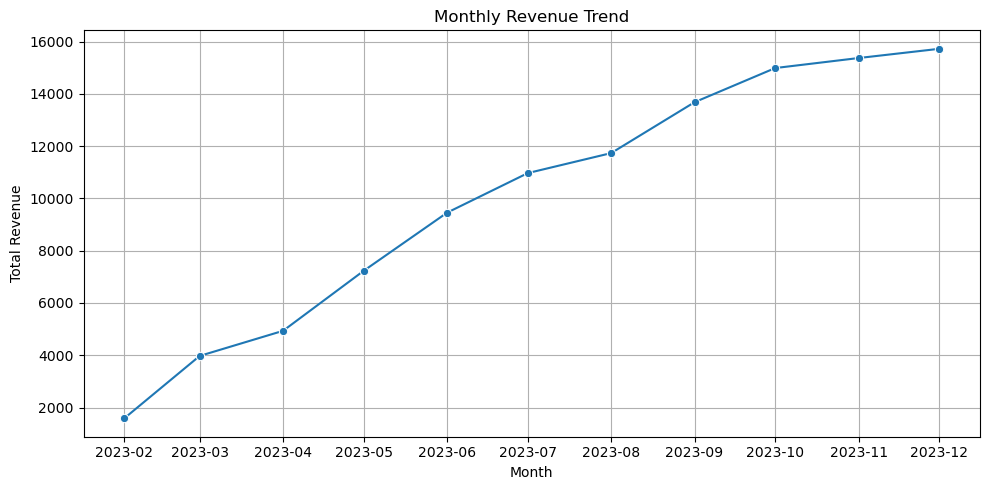

In [5]:
# =====================================
# 1. Monthly Revenue Trend
# =====================================
print("\nCalculating monthly revenue trend...")
revenue_trend = df.groupby('Month')['Monthly_Fee'].sum().reset_index()
print(revenue_trend.head())

plt.figure(figsize=(10, 5))
sns.lineplot(data=revenue_trend, x='Month', y='Monthly_Fee', marker='o')
plt.title('Monthly Revenue Trend')
plt.ylabel('Total Revenue')
plt.xlabel('Month')
plt.grid(True)
plt.tight_layout()
plt.show()


Calculating monthly churn rate...
       Month  Churn_Flag  Churn_Rate (%)
0 2023-02-01    0.437500       43.750000
1 2023-03-01    0.372093       37.209302
2 2023-04-01    0.345455       34.545455
3 2023-05-01    0.308642       30.864198
4 2023-06-01    0.292453       29.245283


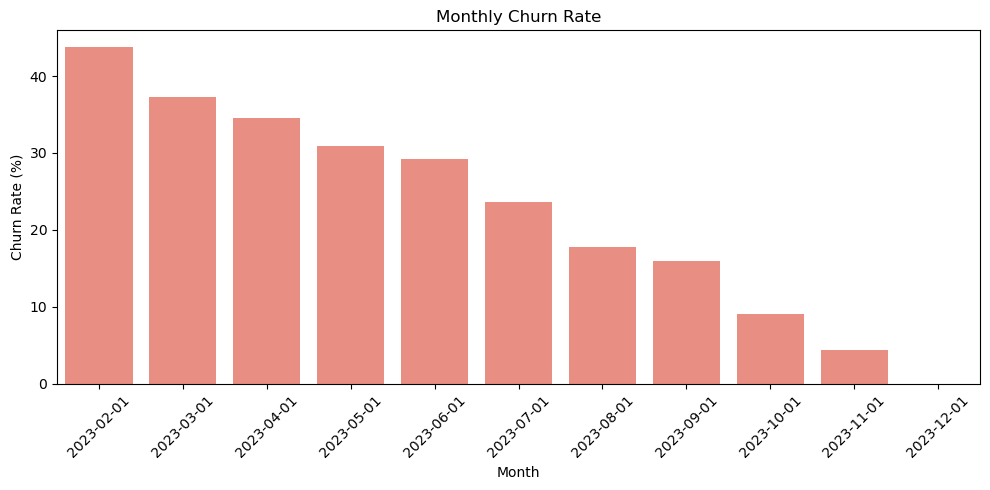

In [6]:
# =====================================
# 2. Monthly Churn Rate
# =====================================
print("\nCalculating monthly churn rate...")
monthly_churn = df.groupby(['Month', 'Customer_ID']).agg({
    'Churn_Flag': 'max'
}).reset_index()

churn_summary = monthly_churn.groupby('Month')['Churn_Flag'].mean().reset_index()
churn_summary['Churn_Rate (%)'] = churn_summary['Churn_Flag'] * 100
print(churn_summary.head())

plt.figure(figsize=(10, 5))
sns.barplot(data=churn_summary, x='Month', y='Churn_Rate (%)', color='salmon')
plt.title('Monthly Churn Rate')
plt.ylabel('Churn Rate (%)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
# =====================================
# 3. Prepare Data for Churn Prediction
# =====================================
print("\nPreparing data for churn prediction...")
latest_month = df['Month'].max()
window_start = latest_month - pd.DateOffset(months=2)
print(f"Using data from: {window_start.date()} to {latest_month.date()}")

churn_df = df[(df['Month'] >= window_start) & (df['Month'] <= latest_month)].copy()

# Use the last record per customer within that window
churn_df = churn_df.sort_values('Month').drop_duplicates('Customer_ID', keep='last')


Preparing data for churn prediction...
Using data from: 2023-10-01 to 2023-12-01


In [8]:
# Encode target
churn_df['Churn_Label'] = churn_df['Churn_Flag'].astype(int)

In [9]:
# Features and target
features = ['Monthly_Fee', 'Usage_Score']
X = churn_df[features]
y = churn_df['Churn_Label']
print("\nChurn label distribution:")
print(y.value_counts())
print("\nFeature sample:")
print(X.head())
print("\nTarget sample:")
print(y.head())



Churn label distribution:
Churn_Label
0    190
1     17
Name: count, dtype: int64

Feature sample:
     Monthly_Fee  Usage_Score
895           71            7
291           82            7
564          120           11
474          145            1
476          137            5

Target sample:
895    1
291    1
564    1
474    1
476    1
Name: Churn_Label, dtype: int64


In [10]:
# Split and train model
print("\nTraining churn prediction model...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


Training churn prediction model...


RandomForestClassifier(random_state=42)

In [11]:
# Evaluation
y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred, labels=[0, 1]))


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        39
           1       0.00      0.00      0.00         3

    accuracy                           0.90        42
   macro avg       0.46      0.49      0.47        42
weighted avg       0.86      0.90      0.88        42


Confusion Matrix:
[[38  1]
 [ 3  0]]
